WISO100303 / Johannes Schmidt & Peter Regner

# **An introduction to scientific programming**

<br> <br> <br> <br><br> <br> <br> <br>

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
FIGSIZE = (12, 12)  # used later for changing figure size

In [3]:
# donwload the data
def download_attached_files():
    import urllib
    import os.path
    fnames = {
              'vienna-map.png': 'https://files.boku.ac.at/filr/public-link/file-download/0d7483c99572915f0195892102336dfd/18659/-4041302498646712195/vienna-map.png',
              'public-toilets.csv': 'https://files.boku.ac.at/filr/public-link/file-download/0d7483c99572915f01958920fab66dd5/18658/-1977532774310129682/public-toilets.csv',
    }
    for fname, url in fnames.items():
        if not os.path.exists(fname):
            urllib.request.urlretrieve(url, filename=fname)

download_attached_files()

# Recap: Numpy arrays

Last time we used `np.array()` to create arrays. There are some other helpful functions to create arrays:

In [4]:
many_ones = np.ones([4,4])
many_ones

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [5]:
many_ones[0]

array([1., 1., 1., 1.])

In [6]:
many_ones[0, 0]

np.float64(1.0)

Note that indexing can be used to assign values too:

In [7]:
many_ones[-1, -1] = 0

In [8]:
many_ones

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 0.]])

In [9]:
many_ones[-1, :] = 0

In [10]:
many_ones

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [0., 0., 0., 0.]])

Today we will focus on more methods to do indexing and slicing of arrays.

# Let's do something with real data

Public toilets in Vienna:
https://www.data.gv.at/datasets/b25202cf-c129-34ca-bdce-d843dd638eaf

Note: we use the order (longitude, latitude) here. This is the order used in shape files and necessary for plotting too.

In [11]:
import urllib
import os.path
from pathlib import Path
import pandas as pd

def read_public_toilets():
    """Download CSV with geocordinates of public toilets in Vienna, parse it and return a numpy
    array of shape (N,2), where each point is (longitude_x, latitude_y)."""
    fname = 'public-toilets.csv'
    if not os.path.exists(fname):
        URI = ('https://data.wien.gv.at/daten/geo?'
               'service=WFS&request=GetFeature&version=1.1.0&'
               'typeName=ogdwien:WCANLAGEOGD&srsName=EPSG:4326&outputFormat=csv')
        urllib.request.urlretrieve(URI, filename=fname)
        
    d = pd.read_csv(fname)
    return d.SHAPE.str.extract(r'POINT \((\d+\.\d+) (\d+\.\d+)\)').astype(float).values

In [12]:
# note that the CSV file will not be re-downloaded from the official website unless it is deleted
# in the Datalore Notebook files without running download_attached_files() at the beginning of the notebook
public_toilets = read_public_toilets()

In [13]:
public_toilets.shape

(191, 2)

In [14]:
public_toilets[:5]

array([[16.33842207, 48.17764075],
       [16.3866226 , 48.17268447],
       [16.22842214, 48.20727516],
       [16.29475754, 48.21520539],
       [16.3147486 , 48.18819816]])

In [15]:
stephansplatz = np.array([16.372223, 48.208432])

In [16]:
# Length of one degree longitude/latitude on Stephansplatz approximately:
LON_TO_KM = 74.1
LAT_TO_KM = 111.19

Doing calculations with longitude/latitude is difficult. Let's project the points to Cartesian coordinates in kilometers with origin at the Stephansplatz. Of course this it's not very accurate to project longitude/latitude that way, but for a small area like Vienna it should be good enough:

In [17]:
def to_km(locations):
    return (locations - stephansplatz) * np.array([LON_TO_KM, LAT_TO_KM])

In [18]:
public_toilets_km = to_km(public_toilets)

In [19]:
public_toilets_km[:5]

array([[ -2.50464918,  -3.42367898],
       [  1.06701018,  -3.97476837],
       [-10.65564377,  -0.12862922],
       [ -5.74019077,   0.75313313],
       [ -4.25885322,  -2.24980091]])

**This is not a good way how to work with maps for larger areas, even if it works reasonably well on small scale. This is just an example of how to use Numpy!**

# Numpy broadcasting rules

<!-- broken in Datalore, see cell below
<img src="numpy_broadcasting.png" width="800">
-->

<small>
Source: [scipy lecture notes](http://scipy-lectures.org/intro/numpy/operations.html#broadcasting) (CC-BY 4.0)
</small>

- operations with Numpy are (mostly) elementwise.
- if the shape does not match, the smaller array is duplicated along missing axis

![Numpy broadcasting rules](images/numpy_broadcasting.png)

Examples:

    A      (2d array):  5 x 4
    B      (1d array):      1
    Result (2d array):  5 x 4

    A      (2d array):  5 x 4
    B      (1d array):      4
    Result (2d array):  5 x 4

    A      (3d array):  15 x 3 x 5
    B      (3d array):  15 x 1 x 5
    Result (3d array):  15 x 3 x 5

Full documentation:
https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html

**How does that work in detail?**

NumPy broadcasting allows arrays of different shapes to undergo element-wise operations.

Sizes of the dimensions are compared, starting with the trailing (i.e. rightmost) one:
- if the sizes match, there is nothing to do
- if the size equals 1 or if there is no size due to a lower number of dimensions, the smaller array is copied along the dimensions to match the shape of the larger array.
- if the sizes do not match and both are >1, an error is raised: "ValueError: operands could not be broadcast together"

**Hint:** With more than two dimensions things get a bit confusing. Consider using the library `xarray` if you need that often!

Ok, so can we plot our data set to get a better overview?

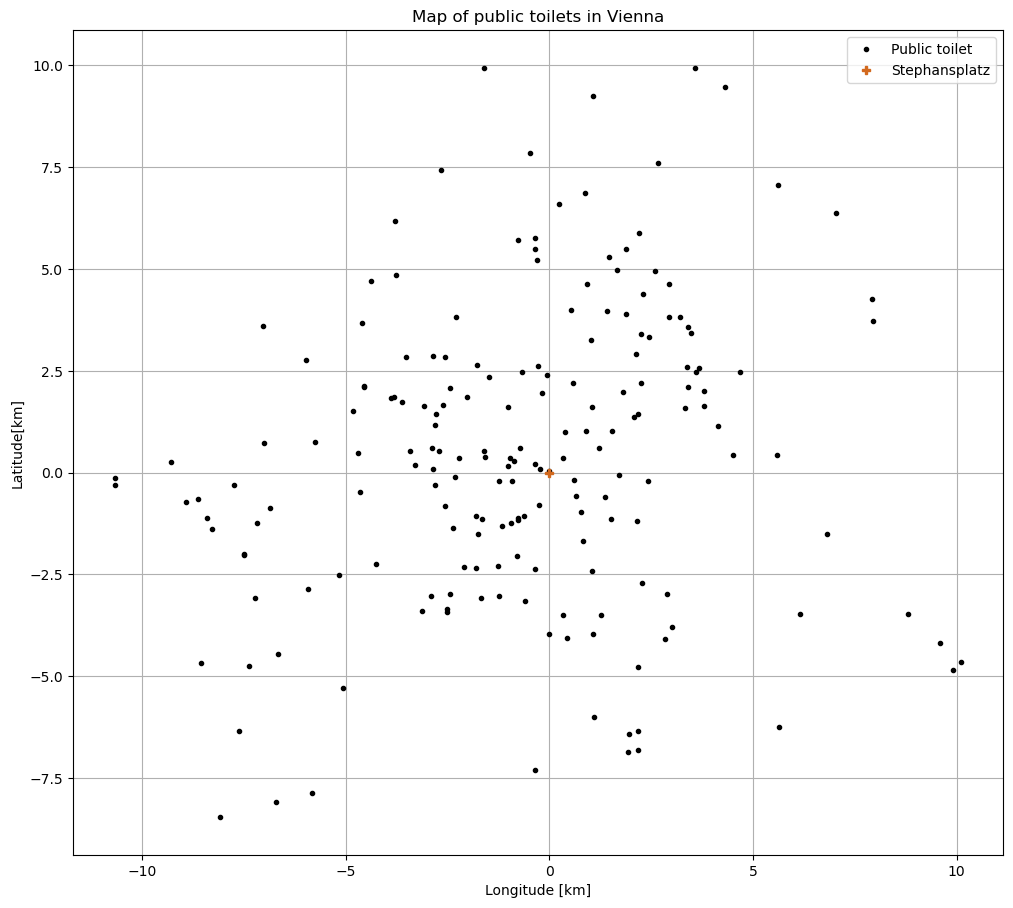

In [20]:
plt.figure(figsize=FIGSIZE)

plt.plot(public_toilets_km.T[0], public_toilets_km.T[1], 'ko', markersize=3, label='Public toilet')
plt.plot([0], [0], 'P', label='Stephansplatz', color='chocolate')

plt.gca().set_aspect('equal')
plt.legend()
plt.title('Map of public toilets in Vienna')
plt.xlabel('Longitude [km]')
plt.ylabel('Latitude[km]')
plt.grid();

# Reading and plotting images

Let's add a simple (inaccurate) map of Vienna (adapted version from [this one](https://commons.wikimedia.org/wiki/Category:Maps_of_Vienna#/media/File:Gemeindebezirke_Wiens.svg), license: public domain). See also [interactive map of public toilets](https://m.wien.gv.at/stadtplan/#base=karte&zoom=12&lat=48.2023&lon=16.4142&layer=wc).

In [21]:
vienna = plt.imread('vienna-map.png')

In [22]:
vienna.shape

(695, 925, 4)

The third dimension here is the color space. If you have never seen RGB values before, you can [google for "color picker"](https://www.google.com/search?q=color+picker) to see a demonstration.

In [23]:
# distance from Stephansplatz to borders of the PNG file in km
left = -13.682179147809752
right = 16.639373238835283
bottom = -9.81358722568525
top = 12.989326274442831
extent = left, right, bottom, top

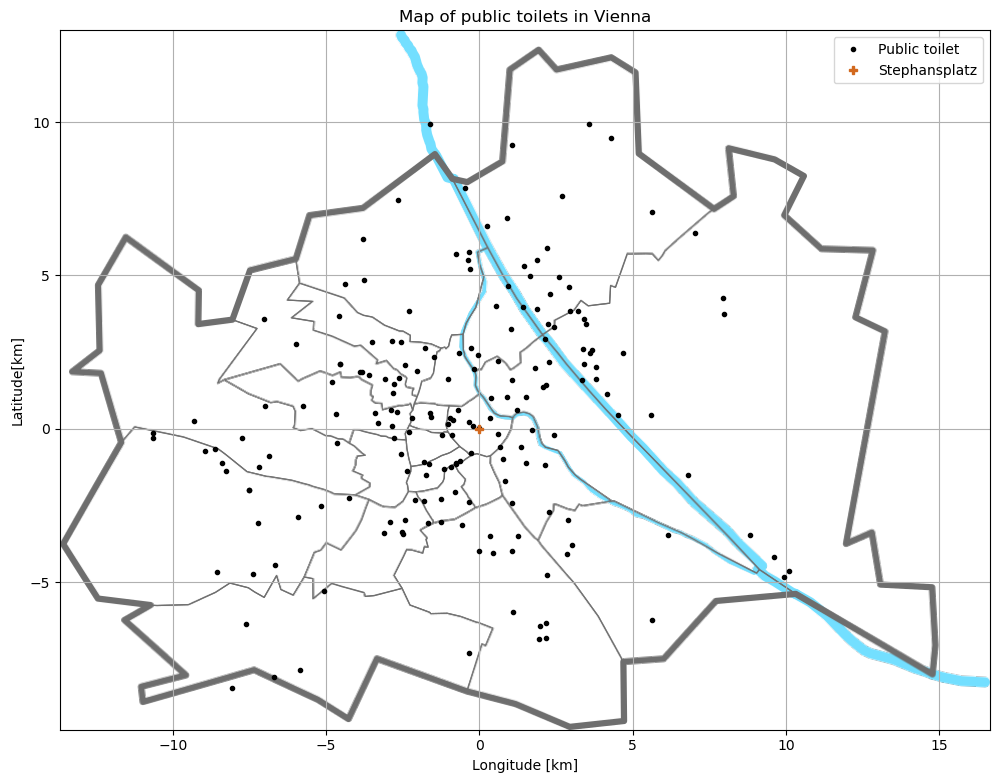

In [24]:
plt.figure(figsize=FIGSIZE)

plt.plot(public_toilets_km.T[0], public_toilets_km.T[1], 'ko', markersize=3, label='Public toilet')
plt.plot([0], [0], 'P', label='Stephansplatz', color='chocolate')
plt.gca().set_aspect('equal')
plt.legend()
plt.title('Map of public toilets in Vienna')
plt.xlabel('Longitude [km]')
plt.ylabel('Latitude[km]')
plt.grid()

plt.imshow(vienna, extent=extent);

There are [better ways to plot geographic maps](https://matplotlib.org/basemap/users/examples.html). This is just a simple example to play with Numpy.

# Distances between locations

In [25]:
def distance(point1, point2):
    """Calculate Euclidean distance between two points. Points are passed
    as lists or arrays of length 2. Numpy arrays of many dimensions are 
    supported: axis=0 must be the dimension for x/y coordinates."""
    return ((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)**0.5

In [26]:
a = np.array([1, 1])
b = np.array([0, 0])

In [27]:
distance(a, b)

np.float64(1.4142135623730951)

In [28]:
you_are_here =  np.array([16.33510244998302, 48.2369092277027])

Unfortunately the array has the wrong shape, the first _axis_ must be the one for x/y coordinates:

In [29]:
public_toilets_km.shape

(191, 2)

Transposing the array solves this problem:

In [30]:
public_toilets_km.T.shape

(2, 191)

Why is this necessary? We can look up how `distance()`:

In [31]:
distance?

Signature: distance(point1, point2)
Docstring:
Calculate Euclidean distance between two points. Points are passed
as lists or arrays of length 2. Numpy arrays of many dimensions are 
supported: axis=0 must be the dimension for x/y coordinates.
File:      /tmp/ipykernel_1779/3750188704.py
Type:      function

In [32]:
distance??

Signature: distance(point1, point2)
Source:   
def distance(point1, point2):
    """Calculate Euclidean distance between two points. Points are passed
    as lists or arrays of length 2. Numpy arrays of many dimensions are 
    supported: axis=0 must be the dimension for x/y coordinates."""
    return ((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)**0.5
File:      /tmp/ipykernel_1779/3750188704.py
Type:      function

In [33]:
public_toilets_km[:4]

array([[ -2.50464918,  -3.42367898],
       [  1.06701018,  -3.97476837],
       [-10.65564377,  -0.12862922],
       [ -5.74019077,   0.75313313]])

In [34]:
public_toilets_km[:4].T

array([[ -2.50464918,   1.06701018, -10.65564377,  -5.74019077],
       [ -3.42367898,  -3.97476837,  -0.12862922,   0.75313313]])

In [35]:
public_toilets_km[0]

array([-2.50464918, -3.42367898])

In [36]:
public_toilets_km.T[0]

array([-2.50464918e+00,  1.06701018e+00, -1.06556438e+01, -5.74019077e+00,
       -4.25885322e+00, -2.88784404e+00, -3.07669093e+00, -7.02342449e+00,
       -3.51358884e+00, -4.38683327e+00, -2.29596950e+00, -7.70587712e-01,
       -1.74063666e+00,  5.94130174e-01,  1.71397008e+00, -1.80944152e+00,
        1.96210444e+00, -8.01495004e-01, -6.66182765e+00,  1.88368913e+00,
       -8.75897864e-01, -7.06289798e-01,  5.63655676e+00,  2.19686039e+00,
       -1.64945123e+00, -3.39802409e-01, -6.19760703e-01, -2.25704391e-01,
       -1.08971468e-03,  2.17513722e+00, -1.66707792e+00, -1.01642321e+00,
        1.45941209e+00,  8.85432556e-01, -1.59565760e-02, -7.49768851e+00,
        3.44975578e-01,  1.93658402e+00,  3.00760527e+00, -7.55540856e-01,
       -2.08742803e+00,  6.63916525e-01,  2.14629215e+00,  1.03188924e+00,
       -1.89689745e-01,  3.80921595e+00, -2.55175596e+00,  6.09137281e-01,
       -9.63267646e-01, -1.01920382e+00, -2.60997704e-01,  1.05972296e+00,
       -8.54543866e+00,  

In [37]:
distances_to_me = distance(public_toilets_km.T, to_km(you_are_here))

In [38]:
distances_to_me[:5]

array([6.59465118, 8.09755764, 8.5642457 , 3.84203486, 5.62225725])

There is a toilet very close, less than 500m!

In [39]:
distances_to_me.min()

np.float64(0.31041700809810724)

Often there is another way to call Numpy functions:

In [40]:
np.min(distances_to_me)

np.float64(0.31041700809810724)

<small>Note: In Numpy, usually there is no difference between these two ways of calling either the function `np.min(distances_to_me)` or the method `distances_to_me.min()`. A convention says methods should be used when the object is modified and the function if a new object is returned. But it this convention is not very widesprad, it is not necessary to stick to it.

But where is the toilet?

In [41]:
closest_idx = distances_to_me.argmin()
closest_idx

np.int64(78)

In [42]:
public_toilets[closest_idx]

array([16.33368289, 48.23428263])

In [43]:
def google_maps_link(location):
    """Return link to turbine in Google maps.
    
    See documentation:
    https://developers.google.com/maps/documentation/urls/guide
    https://stackoverflow.com/questions/47038116/google-maps-url-with-pushpin-and-satellite-basemap

    """
    xlong, ylat = location
    
    # alternative API which does not allow marker
    # f"https://www.google.com/maps/@?api=1&map_action=map&center={ylat},{xlong}&basemap=satellite"
    
    # alternative API which does not allow sattelite
    # f"https://www.google.com/maps/search/?api=1&query={ylat},{xlong}"
    
    # zoom level z=xxx seems to be broken somehow (?)
    return f"http://maps.google.com/maps?q=loc:{ylat}+{xlong}&z=13"

In [44]:
print(google_maps_link(public_toilets[closest_idx]))

http://maps.google.com/maps?q=loc:48.234282632362216+16.33368288716691&z=13


In [45]:
print(google_maps_link(you_are_here))

http://maps.google.com/maps?q=loc:48.2369092277027+16.33510244998302&z=13


In [46]:
def osm_location_link(location, zoom_level):
    """Return link to location in openstreetmaps."""
    xlong, ylat = location
    return f"https://www.openstreetmap.org/?mlat={ylat}&mlon={xlong}#map={zoom_level}/{ylat}/{xlong}"

In [47]:
print(osm_location_link(public_toilets[closest_idx], 15))

https://www.openstreetmap.org/?mlat=48.234282632362216&mlon=16.33368288716691#map=15/48.234282632362216/16.33368288716691


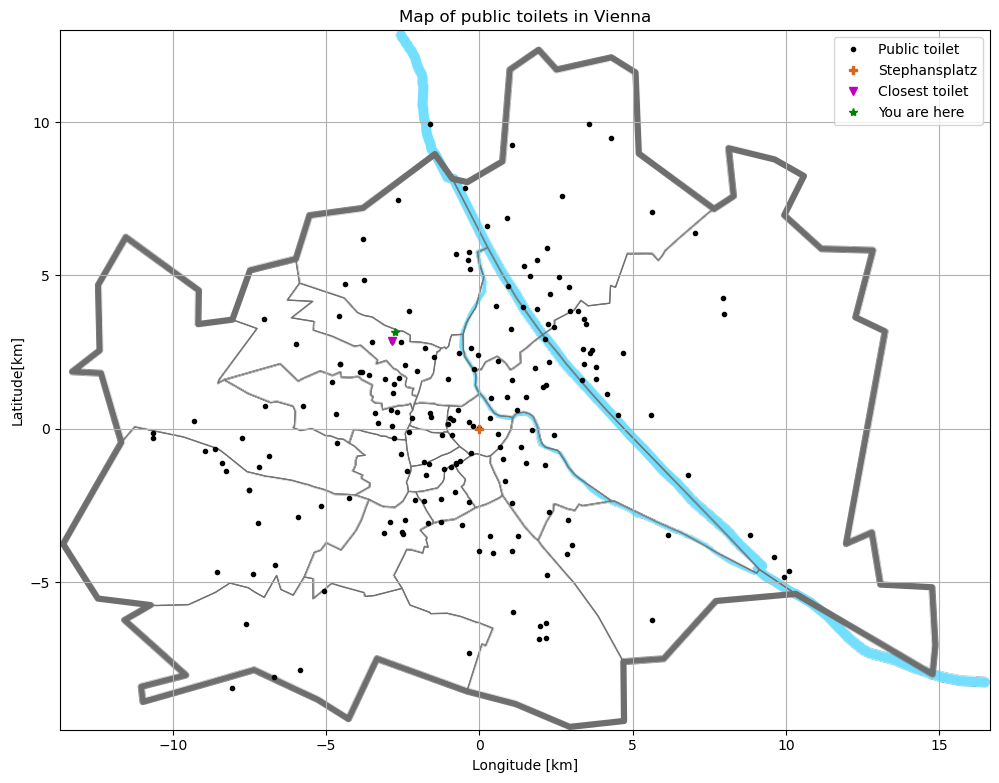

In [48]:
plt.figure(figsize=FIGSIZE)

plt.plot(public_toilets_km.T[0], public_toilets_km.T[1], 'ko', markersize=3, label='Public toilet');
plt.plot([0], [0], 'P', label='Stephansplatz', color='chocolate')
plt.gca().set_aspect('equal')
plt.title('Map of public toilets in Vienna')
plt.xlabel('Longitude [km]')
plt.ylabel('Latitude[km]')
plt.grid()

plt.imshow(vienna, extent=extent)

plt.plot(public_toilets_km.T[0][closest_idx], public_toilets_km.T[1][closest_idx],
         'mv', label='Closest toilet')
plt.plot(*to_km(you_are_here), '*g', label='You are here')

plt.legend();

## Exercise 1 - Find the hottest year

Find the hottest year!

<small>Data source: https://www.wien.gv.at/statistik/wetter/</small>

In [49]:
years = np.array([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975,
                  1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
                  1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
                  2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013])

mean_temperature_celsius = np.array([10.2, 8.6, 8.7, 9.1, 8.6, 10.1, 10.2, 9.7, 9.2, 9.2, 9.8, 9.3, 9.6,
                                     10.2, 10.1, 9.6, 10.1, 9.1, 9.6, 8.7, 10.1, 10.0, 10.8, 9.4, 9.0, 9.6,
                                     9.3, 10.4, 10.7, 10.9, 9.7, 11.1, 10.8, 11.8, 10.4, 8.9, 10.0, 10.8,
                                     10.7, 11.7, 10.6, 11.3, 11.0, 10.4, 10.2, 10.7, 11.7, 11.4, 11.0, 9.9,
                                     11.1, 11.3, 10.9])

In [50]:
### BEGIN SOLUTION

In [51]:
np.max(mean_temperature_celsius)

np.float64(11.8)

In [52]:
years[np.argmax(mean_temperature_celsius)]

np.int64(1994)

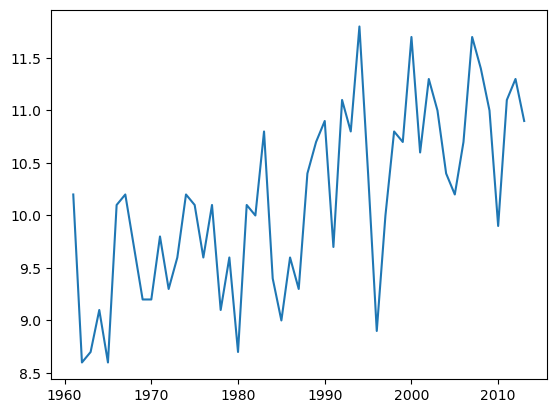

In [53]:
plt.plot(years, mean_temperature_celsius)

In [54]:
### END SOLUTION

<div style="color:#555;border-top:1px solid #999;text-align:right;padding:4px;">End of exercise</div>

# How many close toilets are there?

In [55]:
distances_to_me < 1.

array([False, False, False, False, False, False, False, False,  True,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [56]:
np.sum(distances_to_me < 1.)

np.int64(4)

## Exercise 2 - How many hot years?

Count how many hot years there are with more than 11°C in average (use the data from exercise 1).

In [57]:
### BEGIN SOLUTION

In [58]:

np.sum(mean_temperature_celsius > 11.)

np.int64(8)

In [59]:
### END SOLUTION

<div style="color:#555;border-top:1px solid #999;text-align:right;padding:4px;">End of exercise</div>

# Indexing arrays in multiple dimensions

We have seen already that indexing works with square brackets:

In [60]:
public_toilets[0]

array([16.33842207, 48.17764075])

Numpy supports indexing also in more than one dimension:

In [61]:
public_toilets[0, 1]

np.float64(48.17764075093265)

The slice operations with `:` work also in multiple dimensions:

In [62]:
public_toilets[:3, 0:1]

array([[16.33842207],
       [16.3866226 ],
       [16.22842214]])

In [63]:
some_toilets = public_toilets[:4, :]
some_toilets

array([[16.33842207, 48.17764075],
       [16.3866226 , 48.17268447],
       [16.22842214, 48.20727516],
       [16.29475754, 48.21520539]])

Note that passing `:` as second index, is equivalent to omitting the second index for a 2D Numpy array:

In [64]:
public_toilets[:4]

array([[16.33842207, 48.17764075],
       [16.3866226 , 48.17268447],
       [16.22842214, 48.20727516],
       [16.29475754, 48.21520539]])

One can also pick more than one element at once by providing a list of indices:

In [65]:
public_toilets[[0,3,5]]

array([[16.33842207, 48.17764075],
       [16.29475754, 48.21520539],
       [16.33325075, 48.2137866 ]])

The later is also called [fancy indexing](https://scipy-lectures.org/intro/numpy/array_object.html#fancy-indexing).

# Filtering: Fancy indexing using boolean arrays

Recall: we calculated the distance from our current position to each toilet and then created a boolean array which is `True` for each toilet closer than 1km:

In [66]:
distances_to_me

array([ 6.59465118,  8.09755764,  8.5642457 ,  3.84203486,  5.62225725,
        2.57466376,  1.56444023,  4.29400334,  0.83215999,  2.25195294,
        0.7989746 ,  3.21517474,  4.77322258,  3.48216531,  5.50390826,
        5.59778695, 10.68499508,  5.56966233,  8.5604981 ,  5.1898014 ,
        3.44002225,  3.2723769 , 12.60758112,  5.64475822,  4.44893741,
        3.81027129,  4.73300865,  3.98775742,  4.17140195,  5.22096229,
        6.33590163,  2.33255414,  4.71561213,  5.17988288,  7.64282087,
        7.02400649,  7.35274808, 11.06806702,  9.03431759,  4.72713131,
        5.51814851,  5.07186991,  6.54940717,  3.78376934,  2.83602653,
        6.66215551,  3.98661227,  4.73561511,  3.3375805 ,  3.47448529,
        4.68283598,  6.76842019,  9.74505237,  6.40199588,  4.76090887,
        7.67694793,  4.27617841, 10.71712491, 11.44535308,  4.18050298,
        4.55195056,  3.84791649,  5.64610679, 10.74389259,  8.75910184,
        8.63671172,  5.87350924,  9.45744078,  5.58810788,  7.47

In [67]:
distances_to_me < 1.

array([False, False, False, False, False, False, False, False,  True,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [68]:
is_close_to_me = distances_to_me < 1.

This boolean array can be used to select entries of the array:

In [69]:
close_toilets = public_toilets_km[is_close_to_me]
close_toilets

array([[-3.51358884,  2.83413565],
       [-2.2959695 ,  3.82337742],
       [-2.85582236,  2.87433181],
       [-2.56921897,  2.84118034]])

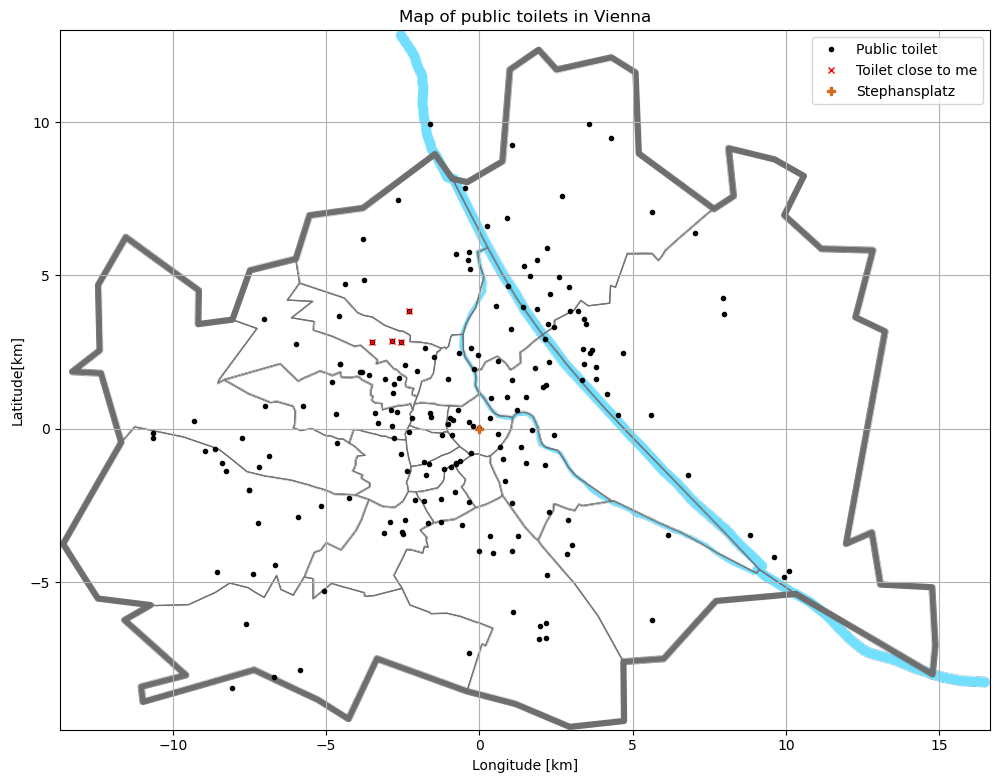

In [70]:
plt.figure(figsize=FIGSIZE)

plt.plot(*public_toilets_km.T, 'ko', markersize=3, label='Public toilet')
plt.plot(*close_toilets.T, 'rx', markersize=5, label='Toilet close to me')

plt.plot([0], [0], 'P', label='Stephansplatz', color='chocolate')
plt.gca().set_aspect('equal')
plt.legend()
plt.title('Map of public toilets in Vienna')
plt.xlabel('Longitude [km]')
plt.ylabel('Latitude[km]')
plt.grid()

plt.imshow(vienna, extent=extent);

## Exercise 3 - Which are the hot years?

Find the years with more than 11°C average temperature (use the data from exercise 1).

Bonus: find the coldest years, i.e. years with average temperature less than 9°C.

In [71]:
### BEGIN SOLUTION

In [72]:
print(years[mean_temperature_celsius > 11.0])

[1992 1994 2000 2002 2007 2008 2011 2012]


In [73]:
print(years[mean_temperature_celsius < 9.])

[1962 1963 1965 1980 1996]


In [74]:
### END SOLUTION

<div style="color:#555;border-top:1px solid #999;text-align:right;padding:4px;">End of exercise</div>

## Exercise 4 - Temperature via indices

Use fancy index techniques to print the years and temperatures from exercise 2 for the given indices.

In [75]:
indices = np.array([0, -2, -1])

In [76]:
### BEGIN SOLUTION

In [77]:
print("Temperatures", mean_temperature_celsius[indices])
print("Years", years[indices])

Temperatures [10.2 11.3 10.9]
Years [1961 2012 2013]


In [78]:
### END SOLUTION

<div style="color:#555;border-top:1px solid #999;text-align:right;padding:4px;">End of exercise</div>

# bonus part

# Adding a new axis

One can even create new dimensions:

In [79]:
some_toilets.shape

(4, 2)

In [80]:
some_toilets[:, :, np.newaxis].shape

(4, 2, 1)

In [81]:
some_toilets[:, :, np.newaxis]

array([[[16.33842207],
        [48.17764075]],

       [[16.3866226 ],
        [48.17268447]],

       [[16.22842214],
        [48.20727516]],

       [[16.29475754],
        [48.21520539]]])

# More advanced broadcasting

In [82]:
a = np.arange(5)
a

array([0, 1, 2, 3, 4])

We can use `np.ones()` to create a column vector, i.e. an array of shape `(n, 1)`:

In [83]:
b = np.ones((5, 1)) * 2
b

array([[2.],
       [2.],
       [2.],
       [2.],
       [2.]])

In [84]:
b.shape

(5, 1)

In [85]:
a * b

array([[0., 2., 4., 6., 8.],
       [0., 2., 4., 6., 8.],
       [0., 2., 4., 6., 8.],
       [0., 2., 4., 6., 8.],
       [0., 2., 4., 6., 8.]])

# Fancy indexing with toilets 

Let's create a discrete grid covering Vienna. We will use a cartesian coordinate system in kilometers with origin at the Stephansplatz:

In [86]:
x = np.linspace(left, right, num=150)
y = np.linspace(bottom, top, num=150)

In [87]:
x[:5]

array([-13.68217915, -13.4786788 , -13.27517844, -13.07167809,
       -12.86817774])

`xx` is an 2D array where each element contains the x coordinate of corresponding grid point, `yy` contains the y coordinates:

In [88]:
xx, yy = np.meshgrid(x, y)

In [89]:
xx.shape

(150, 150)

In [90]:
yy.shape

(150, 150)

Note that all values in each column are the same, because the x coordinate does not change in that direction:

In [91]:
xx[:3, :3]

array([[-13.68217915, -13.4786788 , -13.27517844],
       [-13.68217915, -13.4786788 , -13.27517844],
       [-13.68217915, -13.4786788 , -13.27517844]])

To allow broadcasting between `public_toilets_km` and `xx` and `yy` new dimensions of size 1 are needed:

In [92]:
public_toilets_km.shape

(191, 2)

In [93]:
public_toilets_km_grid = public_toilets_km.T[:, :, np.newaxis, np.newaxis]
public_toilets_km_grid.shape

(2, 191, 1, 1)

In [94]:
grid = np.array([xx, yy])[:, np.newaxis, :, :]
grid.shape

(2, 1, 150, 150)

For each grid pixel there is a distance calculation to each toilet:

In [95]:
distances = distance(grid, public_toilets_km_grid)
distances.shape

(191, 150, 150)

Let's find the closest toilet for each grid pixel!

In [96]:
min_distance = distances.min(axis=0)

In [97]:
min_distance.shape

(150, 150)

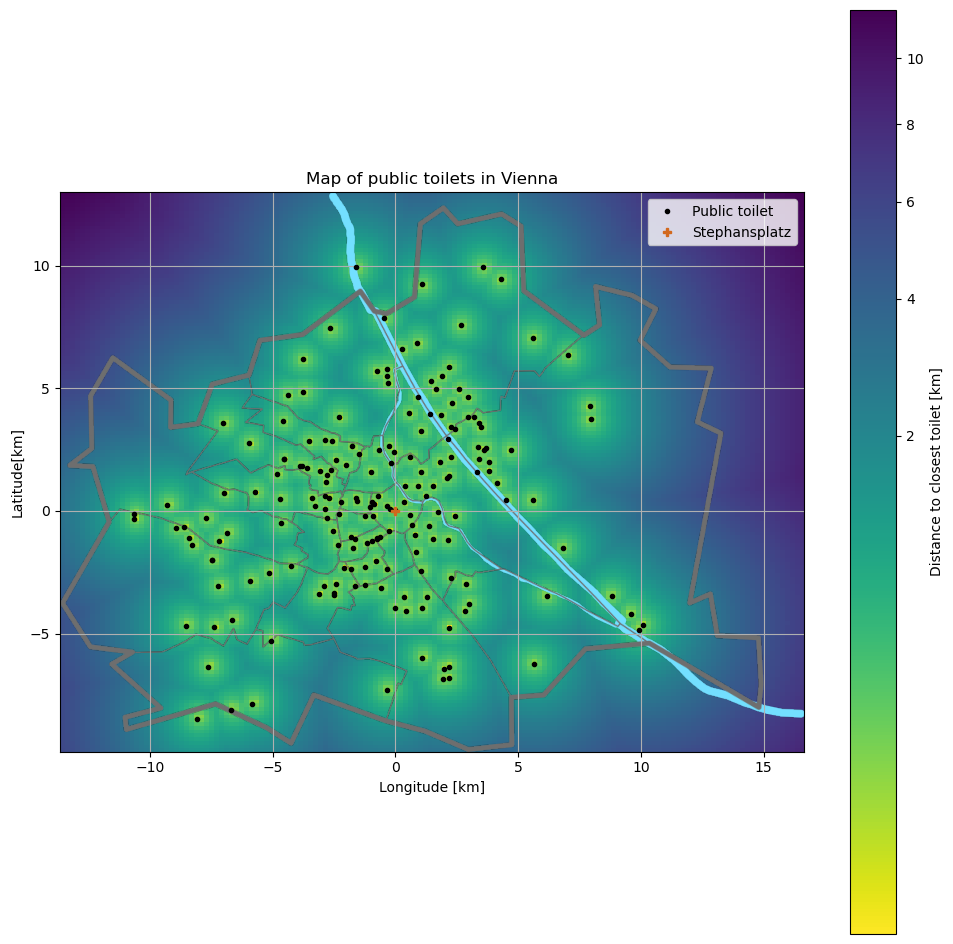

In [98]:
plt.figure(figsize=FIGSIZE)

plt.plot(public_toilets_km.T[0], public_toilets_km.T[1], 'ko', markersize=3, label='Public toilet')
plt.plot([0], [0], 'P', label='Stephansplatz', color='chocolate')
plt.gca().set_aspect('equal')
plt.legend()
plt.title('Map of public toilets in Vienna')
plt.xlabel('Longitude [km]')
plt.ylabel('Latitude[km]')
plt.grid()

plt.imshow(min_distance, extent=extent, origin='lower',
           cmap='viridis_r',
           norm=matplotlib.colors.PowerNorm(0.35)
)
plt.colorbar(label='Distance to closest toilet [km]')
plt.imshow(vienna, extent=extent);

## Exercise 5 - Plot a two dimensional Gaussian

Plot the [two dimensional Gaussian function](https://en.wikipedia.org/wiki/Gaussian_function#Two-dimensional_Gaussian_function):
$$
    g(x,y) = \exp\left(- \left(\frac{x^2}{2\sigma_X^2} + \frac{y^2}{2\sigma_Y^2} \right)\right)
$$

Plot the function in the range $x=-10,\ldots,10$ and $y=-10,\ldots,10$ and use $\sigma_X=10$ and $\sigma_Y=7$.

In [99]:
### BEGIN SOLUTION

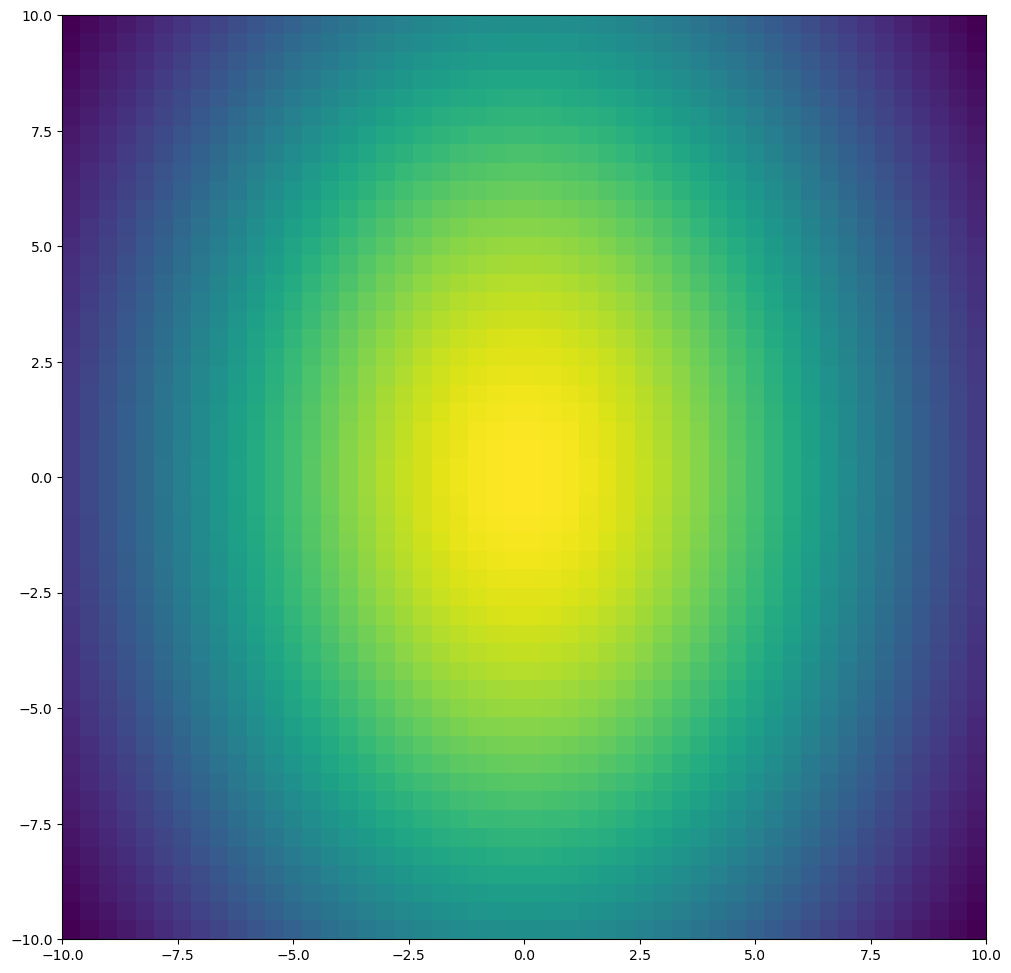

In [100]:
plt.figure(figsize=FIGSIZE)

sy = 7
sx = 10
x = np.linspace(-10, 10)[:, np.newaxis]
y = np.linspace(-10, 10)

plt.imshow(np.exp(-(x**2/(2*sx**2) + y**2/(2*sy**2))), extent=[-10, 10, -10, 10])

In [101]:
### END SOLUTION

<div style="color:#555;border-top:1px solid #999;text-align:right;padding:4px;">End of exercise</div>

## Exercise 6 - Find optimum in plot

Alice wants to produce toilet paper. She can choose production costs per pallet freely between 5 and 40 EUR and the price between 15 and 70 EUR. Higher costs will lead to more products sold (due to higher quality), a higher price will lead to less products sold.

Assume the number of sold items is given by:
$$
    n = 1e5 \cdot \frac{\log(\textrm{costs})}{\textrm{price}^{0.6}}
$$

The profit is given by:

$$
    \textrm{profit} = n \cdot (\textrm{price} - \textrm{costs})
$$

Set discrete values for `costs` and `price` using `np.linspace()`. Then convert costs to a column vector using 

```costs = costs[:, np.newaxis]```
    
(check the shape before and after!). Then calculate the profit.

Plot the profit using `plt.imshow()` and analyze the parameters for the maximum profit!

Use following additional parameters for `plt.imshow()`:

`
extent=[price.min(), price.max(),
       costs.min(), costs.max()],
origin='lower'
`

Use the command `plt.colorbar()` to add a color legend.

In [102]:
### BEGIN SOLUTION

In [103]:

costs = np.linspace(5, 40)[:, np.newaxis]
price = np.linspace(15, 70)

num_sold_items = 1e5 * np.log(costs)/(price**0.6)
profit = num_sold_items * (price - costs)

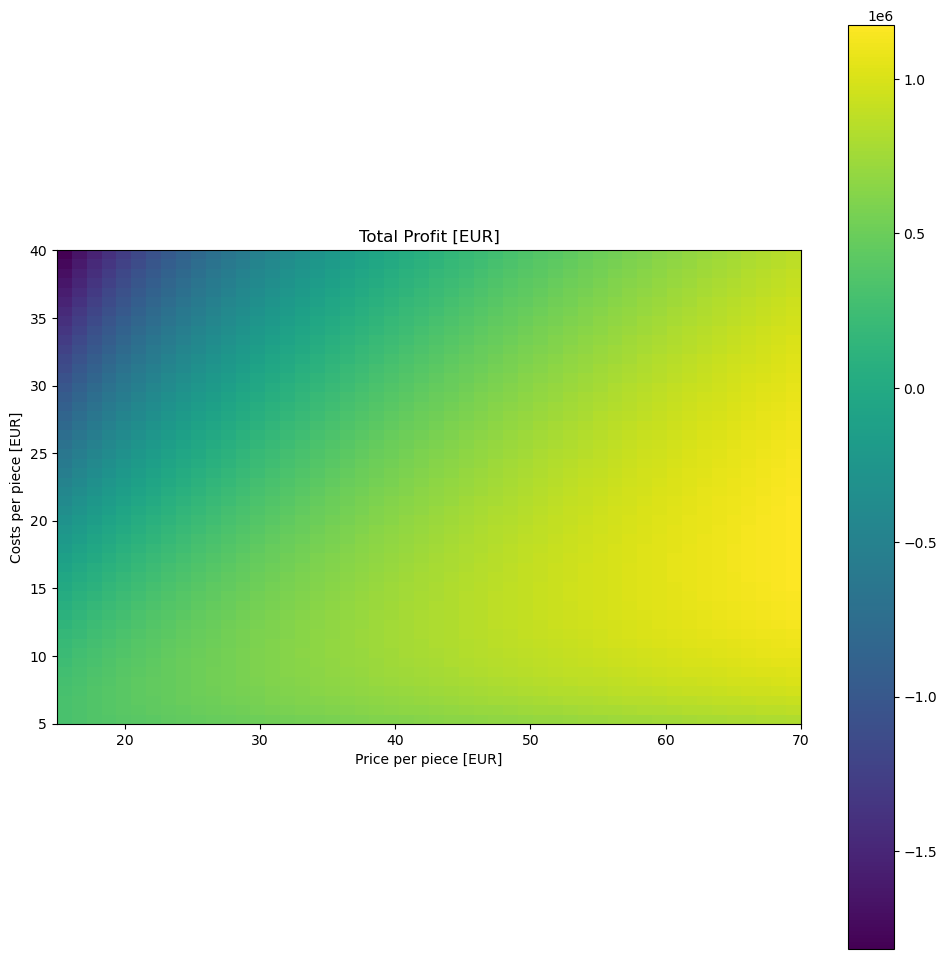

In [104]:
plt.figure(figsize=FIGSIZE)

plt.imshow(profit,
           extent=[price.min(), price.max(),
                   costs.min(), costs.max()],
           origin='lower'
)
plt.colorbar();
plt.title('Total Profit [EUR]')
plt.xlabel('Price per piece [EUR]')
plt.ylabel('Costs per piece [EUR]');

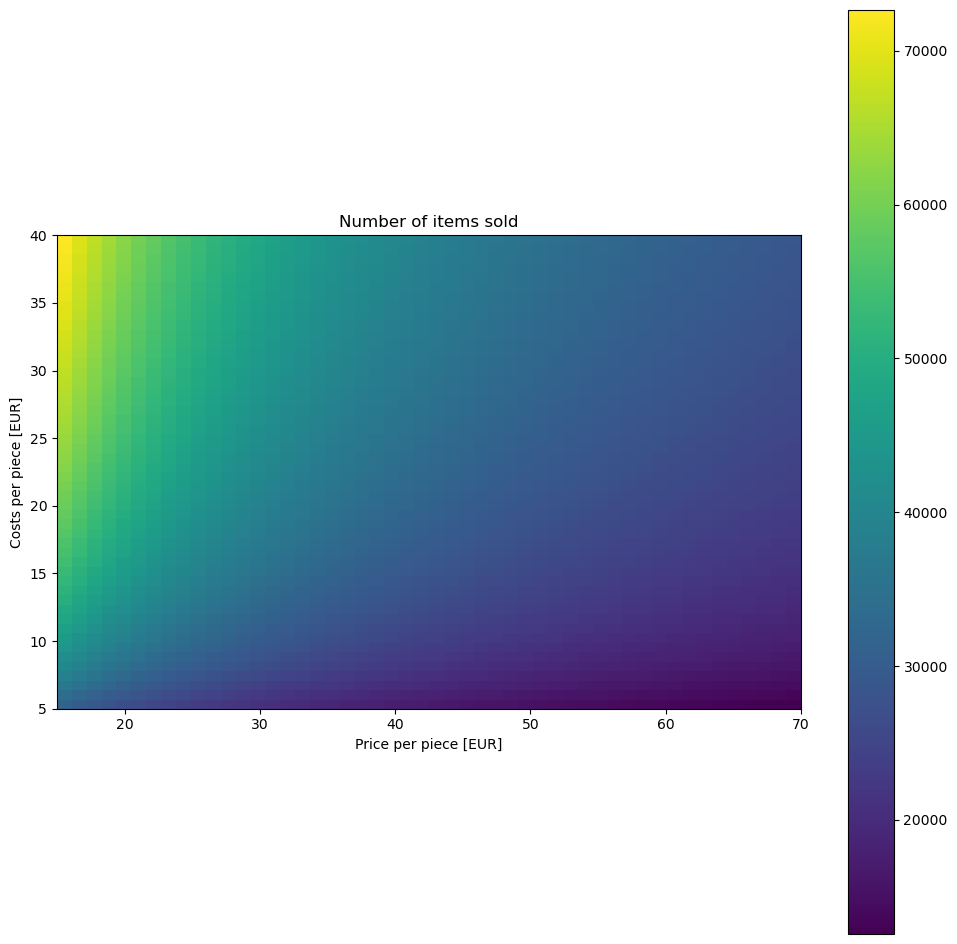

In [105]:
plt.figure(figsize=FIGSIZE)

plt.imshow(num_sold_items,
           extent=[price.min(), price.max(),
                   costs.min(), costs.max()],
           origin='lower')
plt.colorbar();
plt.title('Number of items sold')
plt.xlabel('Price per piece [EUR]')
plt.ylabel('Costs per piece [EUR]');

In [106]:
### END SOLUTION

<div style="color:#555;border-top:1px solid #999;text-align:right;padding:4px;">End of exercise</div>

# Worst spot for urgent needs

Which are the worst spots for urgent needs, where you should avoid drinking beer outside?

<small>(At the moment, drinking beer outside is still better than inside with someone you are not living together anyway!)</small>

In [107]:
from scipy.ndimage import maximum_filter

A maximum filter sets each element to the maximum value of its surroundings:

In [108]:
maximum_filter([1, 1, 1, 5, 1, 1, 1], size=3)

array([1, 1, 5, 5, 5, 1, 1])

This is a very neat trick to find local maxima in a discrete data set:

In [109]:
is_peak = maximum_filter(min_distance, 10) == min_distance

`is_peak` is True, if all the element is at least as large as all others in the surrounding. Such a point is a local maximum.

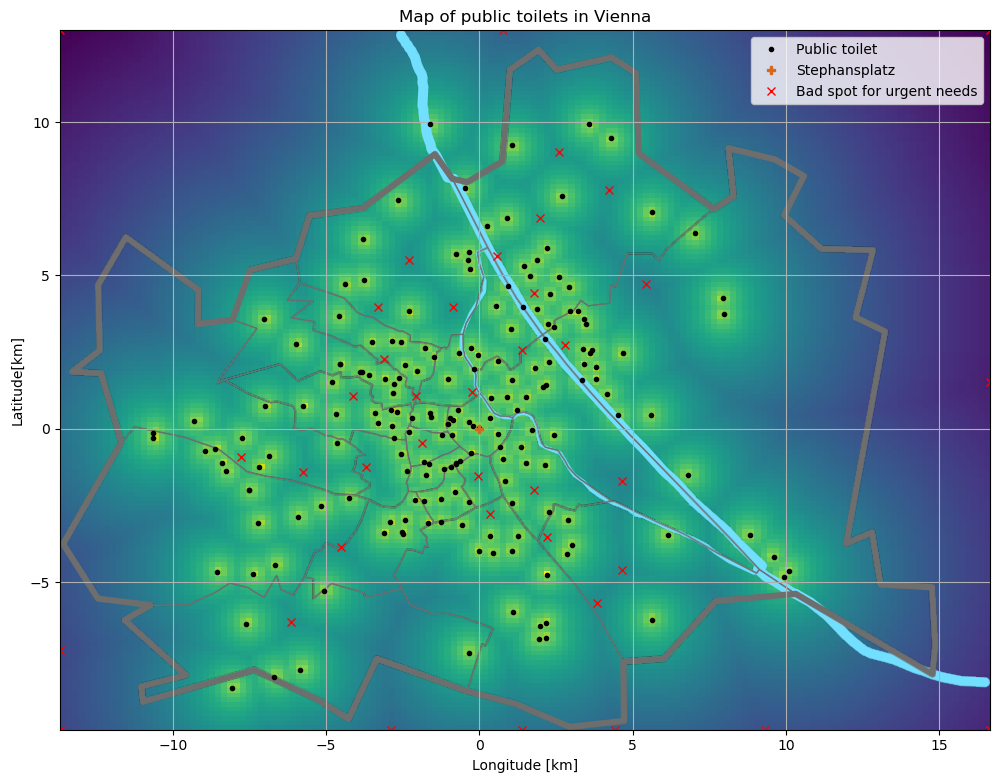

In [110]:
plt.figure(figsize=FIGSIZE)

plt.plot(public_toilets_km.T[0], public_toilets_km.T[1], 'ko', markersize=3, label='Public toilet')
plt.plot([0], [0], 'P', label='Stephansplatz', color='chocolate')
plt.gca().set_aspect('equal')

plt.plot(xx[is_peak], yy[is_peak], 'rx', label='Bad spot for urgent needs')

plt.legend()
plt.title('Map of public toilets in Vienna')
plt.xlabel('Longitude [km]')
plt.ylabel('Latitude[km]')
plt.grid()

plt.imshow(min_distance, extent=extent, origin='lower',
           cmap='viridis_r',
           norm=matplotlib.colors.PowerNorm(0.35)
)

plt.imshow(vienna, extent=extent);

# Reshaping arrays

We got a discrete grid of points covering Vienna, each contains the distance to the closest toilet:

In [111]:
min_distance.shape

(150, 150)

In [112]:
min_distance.flatten()

array([ 5.76340084,  5.56578054,  5.36859959, ..., 11.32303948,
       11.48878368, 11.65572403], shape=(22500,))

In [113]:
min_distance.flatten().shape

(22500,)

# Histogram

How likely is it to be close to a public toilet?

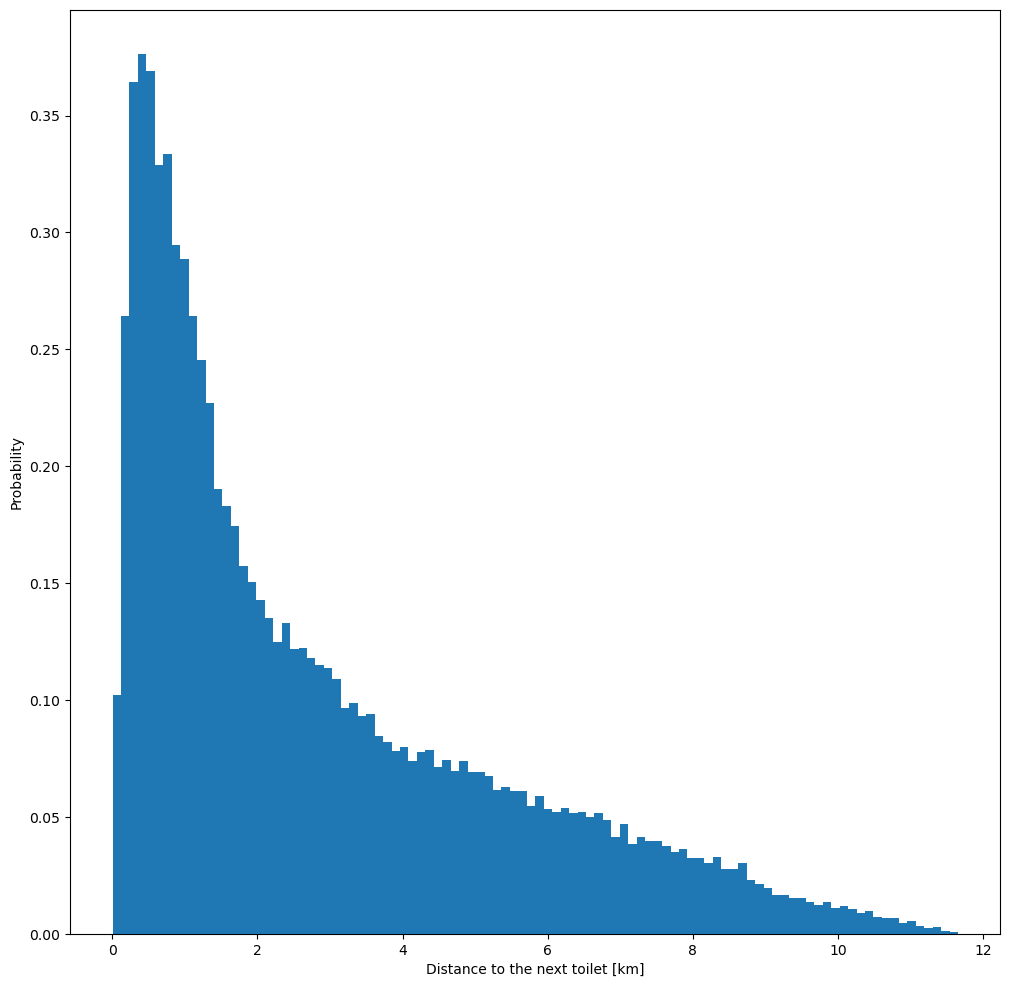

In [114]:
plt.figure(figsize=FIGSIZE)

plt.hist(min_distance.flatten(), bins=100, density=True)
plt.xlabel('Distance to the next toilet [km]')
plt.ylabel('Probability');

But this uses all pixels in the grid... Wouldn't it be more interesting to look only at the center?

Let's filter the grid for all points closer to the center than 8km:

In [115]:
grid[:, 0].shape

(2, 150, 150)

Remember that the center is at `[0, 0]`:

In [116]:
is_central = distance(grid[:, 0], np.zeros((2, 1, 1))) < 8

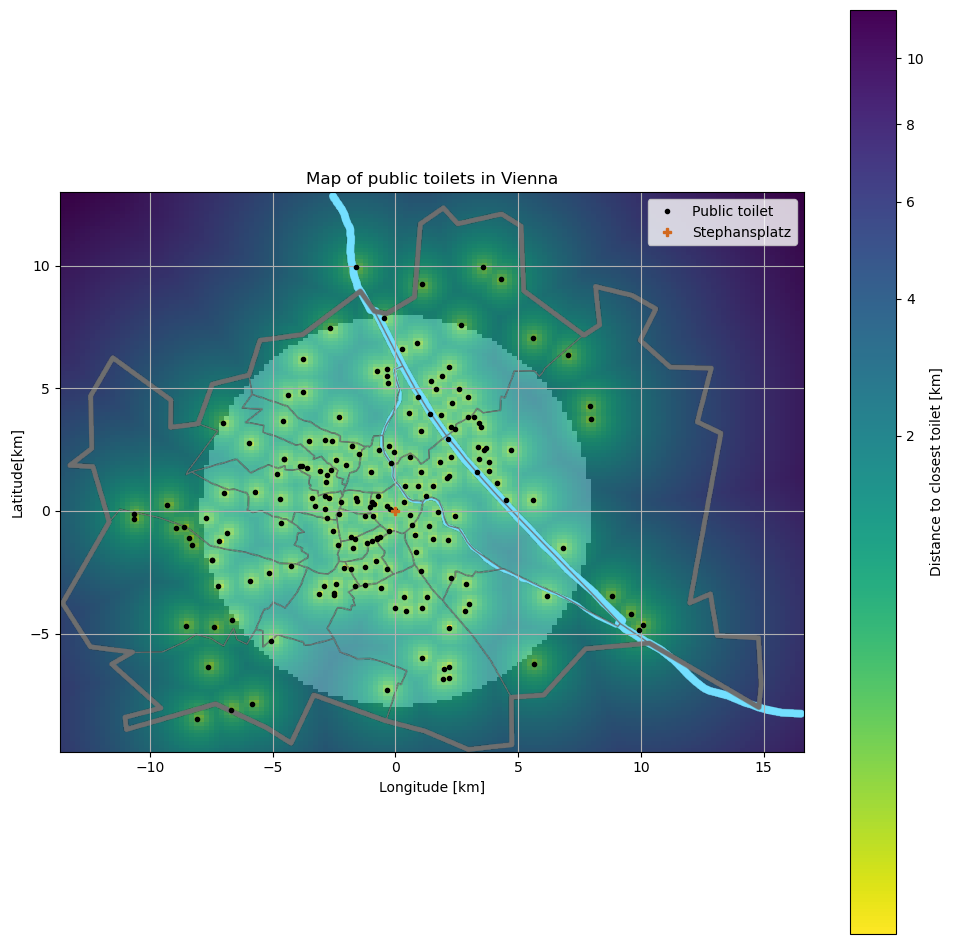

In [117]:
plt.figure(figsize=FIGSIZE)

plt.plot(public_toilets_km.T[0], public_toilets_km.T[1], 'ko', markersize=3, label='Public toilet')
plt.plot([0], [0], 'P', label='Stephansplatz', color='chocolate')
plt.gca().set_aspect('equal')

plt.legend()
plt.title('Map of public toilets in Vienna')
plt.xlabel('Longitude [km]')
plt.ylabel('Latitude[km]')
plt.grid()

plt.imshow(min_distance, extent=extent, origin='lower',
           cmap='viridis_r',
           norm=matplotlib.colors.PowerNorm(0.35)
)

plt.colorbar(label='Distance to closest toilet [km]')

plt.imshow(is_central,
           extent=extent,
           origin='lower',
           cmap='gray',
           alpha=0.2)

plt.imshow(vienna, extent=extent);

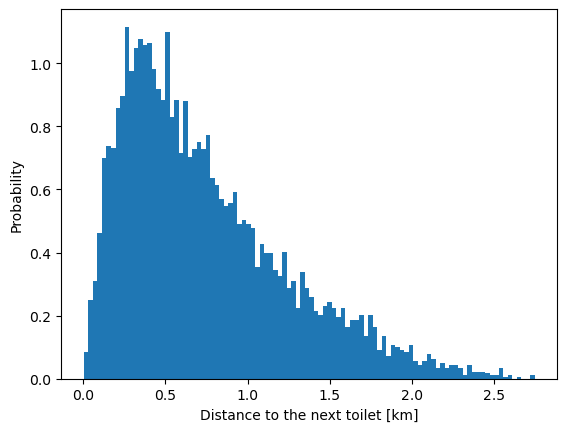

In [118]:
plt.hist(min_distance[is_central], bins=100, density=True)
plt.xlabel('Distance to the next toilet [km]')
plt.ylabel('Probability');

Note that the result is always flat when using a boolean array as index!